# Minimum code for Extended Data Figure 5d qPCR panel

## Load libraries

In [1]:
options(warn = -1)
suppressPackageStartupMessages({
  library(tidyverse)
  library(rasilabRtemplates)
})

In [2]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

## Read in annotations

In [3]:
annotations <- read_csv("../annotations/sampleannotations.csv") %>% 
  mutate(Well = as.character(Well),
         Plate = as.character(Plate)) %>%
  print()

Rows: 96 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Well, Amplicon, sgRNA, Treatment
dbl (1): Plate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 96 × 5
   Plate Well  Amplicon sgRNA Treatment      
   <chr> <chr> <chr>    <chr> <chr>          
 1 1     A09   GAPDH    GCN1  Nilotinib+HHT  
 2 1     A10   GAPDH    GCN1  Vemurafenib+HHT
 3 1     A11   GAPDH    GCN1  GCN2iB+HHT     
 4 1     A12   GAPDH    GCN1  HHT            
 5 1     B09   GAPDH    GCN1  Nilotinib+HHT  
 6 1     B10   GAPDH    GCN1  Vemurafenib+HHT
 7 1     B11   GAPDH    GCN1  GCN2iB+HHT     
 8 1     B12   GAPDH    GCN1  HHT            
 9 1     C09   GAPDH    FLUC  Nilotinib+HHT  
10 1     C10   GAPDH    FLUC  Vemurafenib+HHT
# … with 86 more rows


## Read in Cq data from Cfx Duet

In [4]:
cq_data <- list.files("../../../../data/qpcr/zaki_gcn1_hht/", full.names = T) %>% 
   as_tibble_col("file") %>%
   mutate(data = map(file, . %>% read_csv() %>% as_tibble)) %>%
   mutate(Plate = str_extract(file, "(?<=plate)\\d")) %>%
   unnest("data") %>%
   select(Cq, Well, Plate) %>%
   rename(CT = Cq) %>%
   inner_join(annotations) %>%
   # Remove outlier
   mutate(platewell = str_c(Plate, Well)) %>%
   filter(platewell != "6E03") %>%
   filter(!is.na(CT)) %>%
   mutate(Treatment = fct_relevel(Treatment, "HHT")) %>%
   print()

# cq_data

New names:
• `` -> `...1`
Rows: 96 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Well, Fluor, Content
dbl (8): Cq, Cq Mean, Cq Std. Dev, Starting Quantity (SQ), Log Starting Quan...
lgl (5): ...1, Target, Sample, Biological Set Name, Well Note

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 72 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Well, Fluor, Content
dbl (8): Cq, Cq Mean, Cq Std. Dev, Starting Quantity (SQ), Log Starting Quan...
lgl (5): ...1, Target, Sample, Biological Set Name, Well Note

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("Well", "Plate")


# A tibble: 94 × 7
      CT Well  Plate Amplicon sgRNA Treatment       platewell
   <dbl> <chr> <chr> <chr>    <chr> <fct>           <chr>    
 1  22.4 A09   1     GAPDH    GCN1  Nilotinib+HHT   1A09     
 2  21.9 A10   1     GAPDH    GCN1  Vemurafenib+HHT 1A10     
 3  21.9 A11   1     GAPDH    GCN1  GCN2iB+HHT      1A11     
 4  22.8 A12   1     GAPDH    GCN1  HHT             1A12     
 5  22.4 B09   1     GAPDH    GCN1  Nilotinib+HHT   1B09     
 6  22.2 B10   1     GAPDH    GCN1  Vemurafenib+HHT 1B10     
 7  21.7 B11   1     GAPDH    GCN1  GCN2iB+HHT      1B11     
 8  22.6 B12   1     GAPDH    GCN1  HHT             1B12     
 9  21.3 C09   1     GAPDH    FLUC  Nilotinib+HHT   1C09     
10  21.6 C10   1     GAPDH    FLUC  Vemurafenib+HHT 1C10     
# … with 84 more rows


## Normalize expression to GAPDH

In [7]:
norm_ct_inverted <- cq_data  %>%
  filter(!is.na(CT)) %>%
  group_by(Amplicon, Treatment, sgRNA) %>%
  summarize(std_error = sd(CT),
            n = n(),
            CT = mean(CT)) %>%
  ungroup() %>%
  group_by(Treatment, sgRNA) %>%
  mutate(norm_ct = CT - CT[Amplicon == "GAPDH"],
         norm_error = sqrt(std_error^2 + std_error[Amplicon == "GAPDH"]^2)) %>%
  filter(Amplicon != "GAPDH") %>%
  mutate(norm_ct = 5 - norm_ct) %>%
  write_csv("../../../../source_data/figure_s5d.csv") %>%
  print()

`summarise()` has grouped output by 'Amplicon', 'Treatment'. You can override
using the `.groups` argument.


# A tibble: 16 × 8
# Groups:   Treatment, sgRNA [8]
   Amplicon Treatment       sgRNA std_error     n    CT norm_ct norm_error
   <chr>    <fct>           <chr>     <dbl> <int> <dbl>   <dbl>      <dbl>
 1 EGR1     HHT             FLUC     0.206      3  31.5   -4.56      0.364
 2 EGR1     HHT             GCN1     0.168      3  23.7    3.79      0.271
 3 EGR1     GCN2iB+HHT      FLUC     0.162      3  30.0   -3.48      0.194
 4 EGR1     GCN2iB+HHT      GCN1     0.180      3  30.9   -4.42      0.352
 5 EGR1     Nilotinib+HHT   FLUC     0.0645     3  29.4   -2.98      0.154
 6 EGR1     Nilotinib+HHT   GCN1     0.627      3  30.8   -3.19      0.681
 7 EGR1     Vemurafenib+HHT FLUC     0.0493     3  29.1   -2.72      0.226
 8 EGR1     Vemurafenib+HHT GCN1     0.355      2  29.6   -2.49      0.403
 9 JUN      HHT             FLUC     0.268      3  23.6    3.41      0.403
10 JUN      HHT             GCN1     0.0412     3  20.7    6.85      0.216
11 JUN      GCN2iB+HHT      FLUC     0.0974     

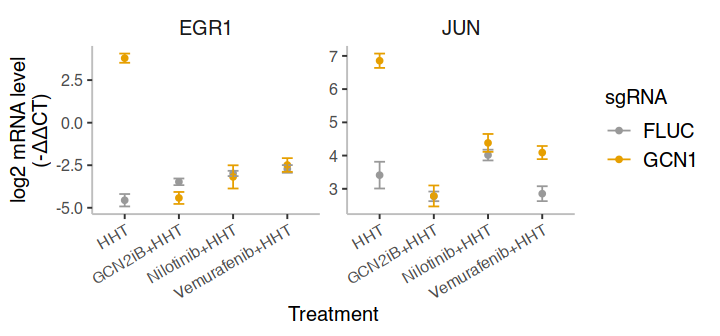

In [6]:
options(repr.plot.width=6, repr.plot.height=2.8)

norm_ct_inverted %>% 
  ggplot(aes(x = Treatment, y = norm_ct, ymax = norm_ct + norm_error, ymin = norm_ct - norm_error, color = sgRNA)) +
  geom_point() +
  geom_errorbar(width = 0.2) +
  facet_wrap(~Amplicon, scales = "free_y") +
  ylab("log2 mRNA level\n(-ΔΔCT)") +
  theme(axis.text.x = element_text()) +
  scale_x_discrete(guide = guide_axis(angle = 30)) +
  theme(axis.line = element_line(color = "grey")) +
  scale_color_manual(values = cbPalette) 

ggsave("../figures/egr1_jun_mrna_levels.pdf", height = 2.8, width = 6) 